In [1]:
from matplotlib import pyplot as plt
import numpy as np
from fpl import FPL
import aiohttp
import asyncio
import pandas as pd
from random import shuffle
from collections import defaultdict
from scipy.stats import skewnorm
print("hello FPL")

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.
hello FPL


### Get 50 players with highest value per dollar and see what happens

In [2]:
async def get_value_data():
    data = pd.DataFrame(columns=['Name', 'position', 'points_per_game', 'minutes', 'now_cost', 'value'])
    position_map = {
        1: "Goalkeeper",
        2: "Defender",
        3: "Midfielder",
        4: "Forward"
    }
    async with aiohttp.ClientSession() as session:
        fpl = FPL(session)
        for i in range(1, 498):
            try :
                player = await fpl.get_player(i)
                value = float(player.points_per_game) / float(player.now_cost)
                name = player.first_name + " " + player.second_name
                data.loc[i] = [name, position_map[player.element_type], float(player.points_per_game), float(player.minutes), float(player.now_cost), float(value)]
            except ValueError:
                print(f"player not found {i}")
    data.sort_values(by = ['value'], inplace = True, ascending = False)
    return data
    
    
value_data = await get_value_data()
value_data.head()

,Name,position,points_per_game,minutes,now_cost,value
494,Gabriel Magalhães,Defender,15.0,90.0,50.0,0.30
461,Romain Saïss,Defender,15.0,90.0,50.0,0.30
485,Jeff Hendrick,Midfielder,14.0,90.0,50.0,0.28
123,Reece James,Defender,14.0,90.0,50.0,0.28
105,Jorge Luiz Frello Filho,Midfielder,12.0,84.0,50.0,0.24


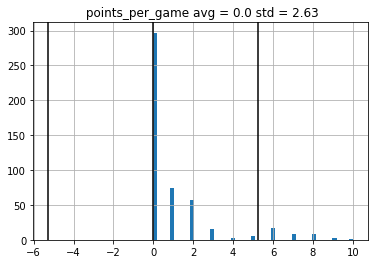

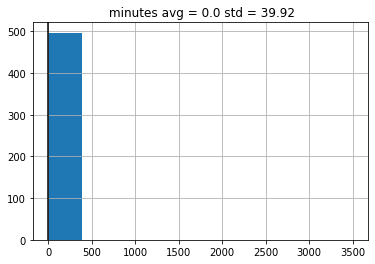

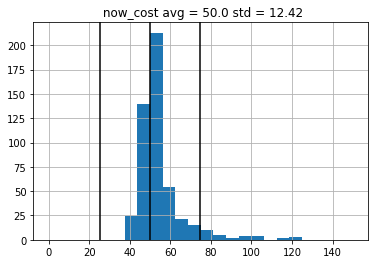

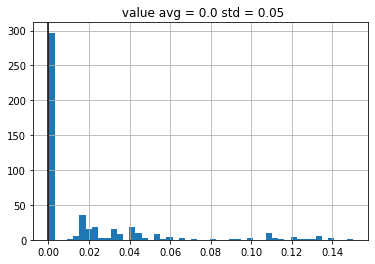

(0.0, 0.05)

In [3]:
def visualize_distribution(data, column, bins, normal  = True):
    median = round(data[column].median(), 2)
    std = round(data[column].std(), 2)
    data[column].hist(bins = bins)
    plt.axvline(median, color = 'black')
    if normal:
        plt.axvline(median - 2 * std, color = 'black')
        plt.axvline(median + 2 * std, color = 'black')
    plt.title(f" {column} avg = {median} std = {std}")
    plt.show()
    return median, std

visualize_distribution(value_data, 'points_per_game', bins = np.linspace(0, 10, 50))
visualize_distribution(value_data, 'minutes', bins = np.linspace(0, 3500, 10), normal = False)
visualize_distribution(value_data, 'now_cost', bins = np.linspace(0, 150, 25))
visualize_distribution(value_data, 'value', bins = np.linspace(0, 0.15, 50), normal = False)

In [4]:
def greedy_random_soft(data, num_forwards, num_midfielders, num_defenders, num_goalkeepers, budget, squad_length, minute_threshold = 1000, a = -1, loc = 0.3, scale = 0.1):
    data = data[data['minutes'] >minute_threshold]
    data['normalized_points_per_game'] = (data['points_per_game'] - data['points_per_game'].mean() )/ data['points_per_game'].std()
    data['normalized_value'] =  (data['value'] - data['value'].mean() )/ data['value'].std()
    soft_scores = skewnorm.rvs(a = a, loc=loc, scale = scale, size=(15, ))
    soft_scores = sorted(soft_scores, reverse=True)
    players_selected = pd.DataFrame(columns=['Name', 'position', 'points_per_game', 'minutes', 'now_cost', 'value'])
    choices = ["Forward"] * num_forwards + ["Midfielder"] * num_midfielders + ["Defender"] * num_defenders + ["Goalkeeper"] * num_goalkeepers
    total_cost = 0
    shuffle(choices)
    for i, soft_score in enumerate(soft_scores):
        choice = choices.pop()
        choice_data = data[(data['position'] == choice) & (data['now_cost'] + total_cost < budget)]
        if not choice_data.shape[0]:
            print("Budget error")
            return pd.DataFrame()
        choice_data['soft_score'] = soft_score * choice_data['normalized_points_per_game'] + (1 - soft_score) * choice_data['normalized_value']
        choice_data.sort_values(by=['soft_score'], inplace = True, ascending = False)
        player_selected = choice_data.iloc[0]
        players_selected.loc[i] = player_selected
        total_cost += player_selected["now_cost"]
        data = data[data["Name"] != player_selected["Name"]]
    players_selected.sort_values(by=['position'], inplace = True)
    return players_selected

def greedy_random_with_superstar(data, num_forwards, num_midfielders, num_defenders, num_goalkeepers, budget, squad_length, num_superstars = 2, superstar_search_width = 25, superstar_minute_threshold = 2000):
    superstar_data = data[data['minutes'] > superstar_minute_threshold]
    superstar_data.sort_values(by='points_per_game', ascending = False, inplace=True)
    superstar_data = superstar_data.head(superstar_search_width)
    superstars = superstar_data.sample(num_superstars)
    value_players_data = data[~(data["Name"].isin(superstars["Name"]))]
    for _, superstar in superstars.iterrows():
        if superstar.position == "Forward": num_forwards -= 1
        elif superstar.position == "Midfielder": num_midfielders -= 1
        elif superstar.position == "GoalKeeper": num_goalkeepers -= 1
        budget -= superstar.now_cost
        squad_length -= 1

    value_players = greedy_random(data, num_forwards, num_midfielders, num_defenders, num_goalkeepers, budget, squad_length)
    if value_players.shape[0] == 0:
        return pd.DataFrame()
    players_selected = pd.concat((superstars, value_players))
    players_selected.sort_values(by=['position'], inplace = True)
    return players_selected
    

def greedy_random(data, num_forwards, num_midfielders, num_defenders, num_goalkeepers, budget, squad_length, search_width = 5):
    expected_points = 0
    players_selected = pd.DataFrame(columns=['Name', 'position', 'points_per_game', 'minutes', 'now_cost', 'value'])
    choices = ["Forward"] * num_forwards + ["Midfielder"] * num_midfielders + ["Defender"] * num_defenders + ["Goalkeeper"] * num_goalkeepers
    total_cost = 0
    shuffle(choices)
    for i in range(squad_length):
        choice = choices.pop()
        choice_data = data[(data['position'] == choice) & (data['now_cost'] + total_cost < budget)]
        if not choice_data.shape[0]:
            print("Budget error")
            return pd.DataFrame()
        choice_data.sort_values(by=['value'], inplace = True, ascending = False)
        player_selected = choice_data.head(search_width).iloc[np.random.randint(search_width)]
        players_selected.loc[i] = player_selected
        total_cost += player_selected["now_cost"]
        data = data[data["Name"] != player_selected["Name"]]
        
    players_selected.sort_values(by=['position'], inplace = True)
    return players_selected
        
def get_max_potential_by_knapsack(value_data, player_type, num_players, budget):
    value_data = value_data[value_data["position"] == player_type]
    players = value_data['Name'].values
    points_per_game = value_data['points_per_game'].values
    costs = value_data['now_cost'].values
    dp = np.zeros((len(players) + 1, budget + 1))
    paths = []
    for i in range(len(players) + 1):
        row = [ [] for j in range(budget + 1)]
        paths.append(row)

    for i in range(1, len(players) + 1):
        for j in range(1, budget + 1):
            dp[i, j] = dp[i-1, j]
            paths[i][j] = list(paths[i-1][j])
            if j >= int(costs[i-1]) and len(paths[i-1][j - int(costs[i-1])]) < num_players :
                if points_per_game[i-1] + dp[i-1, j - int(costs[i-1])] > dp[i, j]:
                    dp[i, j] = points_per_game[i-1] + dp[i-1, j - int(costs[i-1])]
                    paths[i][j] = list(paths[i-1][j - int(costs[i-1])]) + [players[i-1]]
    
    return paths[-1][dp[-1].argmax()]


def dp_knapsack(value_data, num_forwards, num_midfielders, num_defenders, num_goalkeepers, budget, squad_length):
    player_types = np.array(["Goalkeeper", "Defender", "Forward", "Midfielder"])
    num_players = np.array([num_goalkeepers, num_defenders, num_forwards, num_midfielders])
    indices = np.random.permutation(4)
    player_types, num_players = player_types[indices], num_players[indices]
    best_players = []
    budget = 1000
    for i, (player_type, num_player) in enumerate(zip(player_types, num_players)):
        best_players_type = get_max_potential_by_knapsack(value_data, player_type, num_players = num_player, budget = int(budget / (4 - i)))
        
        best_players.extend(best_players_type)
        best_players_type = value_data[value_data['Name'].isin(best_players_type)]
        budget -= best_players_type["now_cost"].sum()
        

    best_squad_dp = value_data[value_data['Name'].isin(best_players)]
    best_squad_dp.sort_values(by=['position'], inplace = True)
    return best_squad_dp


def get_valuable_players(value_data, minute_threshold = 1000, num_forwards = 3, num_midfielders = 5, num_defenders = 5, num_goalkeepers = 2, budget = 1000, squad_length = 15, policy = 'greedy_random'):
    value_data = value_data[value_data["minutes"] > minute_threshold]
    policy_map = { "greedy_random" : greedy_random, "greedy_random_soft" : greedy_random_soft, "greedy_random_with_superstar" : greedy_random_with_superstar, "dp_knapsack" : dp_knapsack}
    policy = policy_map[policy]
    return policy(value_data, num_forwards, num_midfielders, num_defenders, num_goalkeepers, budget, squad_length)

best_squad = None
best_expected_points = -np.inf

results = defaultdict(lambda : defaultdict(list))
for _ in range(50):
    for policy in ['greedy_random',  'greedy_random_with_superstar', 'greedy_random_soft', "dp_knapsack"]:
        squad = get_valuable_players(value_data, policy = policy)
        if not squad.shape[0]:
            points, cost = 0, np.inf
            continue
        else:    
            points, cost = squad['points_per_game'].sum(), squad['now_cost'].sum()
        if points > best_expected_points:
            best_squad = squad
            best_expected_points = points
        results[policy]['expected_points_per_game'].append(points)
        results[policy]['expected_cost'].append(cost)

print(best_expected_points)

Budget error


ValueError: a must be greater than 0 unless no samples are taken

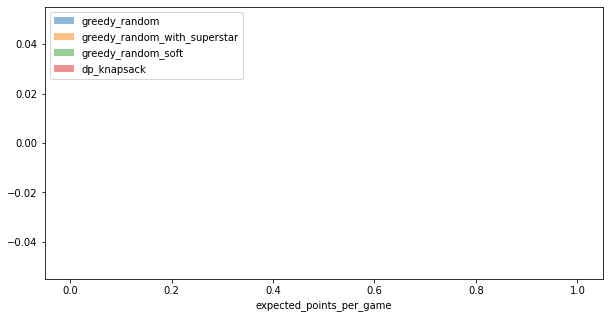

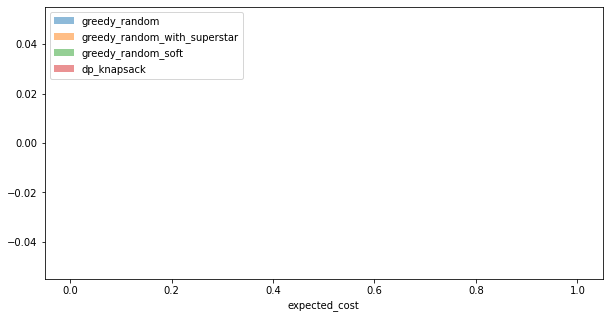

In [5]:
def visualize_results(results, metric):
    plt.figure(figsize=(10, 5))
    for policy in ['greedy_random',  'greedy_random_with_superstar', 'greedy_random_soft', "dp_knapsack"]:
        plt.hist(results[policy][metric], label = policy, alpha = 0.5)
        plt.xlabel(metric)
    plt.legend(loc='upper left')
    plt.show()
visualize_results(results, "expected_points_per_game")
visualize_results(results, "expected_cost")